# 1. Install and import dependencies

## Installation

The first step is to install all the necessary libraries. 

1. Machine Learning libraries:

**- TensorFlow:** For this project, I will use TensorFlow, and as I am using an Apple silicon Mac, I will be running TensorFlow in the Metal API. 

**- Scikit-Learn:** This library is leveraged to split training and testing data and to quantify the precision or the likelihood of the speaker expressing a word on the real-time video feed.

2. Computer Vision libraries:

**- OpenCV** is an open-source Computer Vision library, in this project it is used to enable webcam activation.
**- MediaPipe Holistic** is used to track hand and face features by extracting keypoints.

3. Plotting library:

**- Matplotlib** is used for visual representation of data.

In [2]:
!pip install tensorflow tensorflow-metal opencv-python mediapipe scikit-learn matplotlib

Installation test for MacOS; the following code is a test to see if tensorflow is installed correclty and if it runs smoothly on the Metal API.

import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

## Import

In [3]:
import cv2                                  # Import OpenCV
import numpy as np                          # Import NumPy to help structure arrays (datasets)
import os                                   # To easier work with filepaths
from matplotlib import pyplot as plt        # Import pyplot from Matplotlib
import time                                 # Import time
import mediapipe as mp                      # Import MediaPipe

# 2. Access to webcam using OpenCV and keypoints detection using MediaPipe

In [4]:
# Holistic model to make detection
mp_holistic = mp.solutions.holistic 

# Drawing utilities to draw detection
mp_drawing = mp.solutions.drawing_utils 

In [5]:
# Function to make the detection
def mediapipe_detection(image, model):
    # Convert colors from BGR to RGB (needs to be RGB to make detection in MediaPipe)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # To save space --> make unwriteable image
    image.flags.writeable = False  
    # Make prediction
    results = model.process(image) 
    # Convert back to writeable image
    image.flags.writeable = True  
    # Convert colors from BGR to RGB                 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [6]:
def draw_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(236,138,26), thickness=1, circle_radius=1),  # dot color (remember colors are in BGR )  
                             mp_drawing.DrawingSpec(color=(236,208,26), thickness=1, circle_radius=1)   # line color
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(186,52,25), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(236,103,26), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(0,153,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(51,255,51), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(255,255,102), thickness=2, circle_radius=2)
                             ) 

In [7]:
# Access webcam (video capture device 0 should be the webcam)
cap = cv2.VideoCapture(0)

# Set MediaPipe model 
# What MediaPipe initially does is it detects the keypoints and then tracks
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # Loop through the camera
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read() # return value and frame
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        # Draw landmarks
        draw_landmarks(image, results)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        # Break out of the loop
        if cv2.waitKey(10) & 0xFF == ord('q'):  # if 'q' is hit in keyboard
            break
        
    cap.release()
    cv2.destroyAllWindows()

2024-03-23 15:51:58.902 python[31349:2978008] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.
I0000 00:00:1711227120.122365       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Max
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

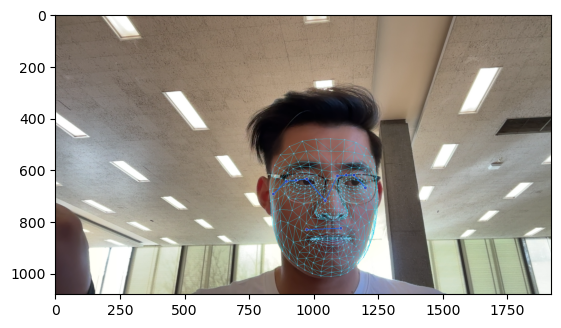

In [8]:
# We have access to the last frame
draw_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

Extract keypoints values into a NumPy array. If no results are gotten in a frame (instance), there will be incompatibility issues as the array will not have the same size. In those cases, a NumPy array of zeros with the same size is leveraged.

print("Length of pose landmarks:", len(results.pose_landmarks.landmark))
print("Length of face landmarks:", len(results.face_landmarks.landmark))
print("Length of left hand landmarks:", len(results.left_hand_landmarks.landmark))
print("Length of right hand landmarks:", len(results.right_hand_landmarks.landmark))

pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
print("Pose shape:", pose.shape)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
print("Face shape:", face.shape)
left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() 
print("Left hand shape:", left_hand.shape)
right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
print("Right hand shape:", right_hand.shape)

In [9]:
def keypoints_extraction(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)                # multiplied by 3 as it has x, y and z components
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)  
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    return np.concatenate([pose, face, left_hand, right_hand])

In [10]:
result_test = keypoints_extraction(results)
result_test.shape

(1662,)

In [11]:
np.save('0', result_test)   # save NumPy array called 0 as .npy

In [12]:
np.load('0.npy')

array([ 0.54492021,  0.66677588, -1.08238173, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup for data collection

In [193]:
# Path for exported data, these are numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Hello', 'I love you', 'Thanks'])
# 'Hello','Thanks' , 'I love you', 'How are you?', 'Nice to meet you!', "What's your name?", 'Deaf', 'Hard of hearing', 'Goodbye','Sorry', 'Good', 'Fine', 'Bad','Excuse me', 'Good morning', 'Good night', 'Hungry', 'Tired', 'Help', 'Busy'

# Number of videos collected per action
no_sequences = 30

# 30 frames each video
sequence_length = 30

# Folder start
start_folder = 30

In [151]:
# Create folders where data is stored
for action in actions:      # loop through actions
    for sequence in range(no_sequences):     # loop through videos
        try:    # just in case the directories are created already to avoid errors
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))  # a folder is created called 'MP_Data', then inside it another folder for each action, and within in action there will be a folder for each sequence/video
        except: # if the folder is created, skip making the directory
            pass

# 5. Collect Keypoint Values for Training and Testing

In [154]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # Loop through actions
    for action in actions:
        # Loop through sequences/videos
        for sequence in range(no_sequences):
            # Loop through video length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_landmarks(image, results)
                # Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), # x and y values of pixels where it is going to be displayed
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA) # font, font size, color in BGR, line width and line type
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(1000)    # wait half a second
                else: # if not in frame 0
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Extract and export keypoints
                keypoints = keypoints_extraction(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Breakq
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

I0000 00:00:1711234711.345095       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Max


# 6. Data Preprocessing

In [194]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [195]:
label_map = {label:num for num, label in enumerate(actions)}

In [196]:
label_map

{'Hello': 0, 'I love you': 1, 'Thanks': 2}

In [197]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [198]:
print(np.array(sequences).shape)
print(np.array(labels).shape)


(90, 30, 1662)
(90,)


In [199]:
X = np.array(sequences)
print(X.shape)

(90, 30, 1662)


In [200]:
y = to_categorical(labels).astype(int)
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)
print(y_test.shape)

(5, 3)


# 7. GRU Neural Network

In [202]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [203]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [204]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [205]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [206]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 8s 2s/step - loss: 8.2477 - categorical_accuracy: 0.3176
Epoch 2/2000
3/3 [==============================] - 6s 2s/step - loss: 39.9451 - categorical_accuracy: 0.2824
Epoch 3/2000
3/3 [==============================] - 6s 2s/step - loss: 63.6963 - categorical_accuracy: 0.3294
Epoch 4/2000
3/3 [==============================] - 5s 2s/step - loss: 10.7258 - categorical_accuracy: 0.3529
Epoch 5/2000
3/3 [==============================] - 6s 2s/step - loss: 15.5927 - categorical_accuracy: 0.3412
Epoch 6/2000
3/3 [==============================] - 6s 2s/step - loss: 27.8168 - categorical_accuracy: 0.4000
Epoch 7/2000
3/3 [==============================] - 6s 2s/step - loss: 75.3244 - categorical_accuracy: 0.3765
Epoch 8/2000
3/3 [==============================] - 6s 2s/step - loss: 71.4775 - categorical_accuracy: 0.3882
Epoch 9/2000
3/3 [==============================] - 6s 2s/step - loss: 13.9569 - categorical_accuracy: 0.3529
Epoch 10/20

KeyboardInterrupt: 

In [ ]:
model.summary()

# 8. Predictions

In [ ]:
prediction = model.predict(X_test)

In [ ]:
actions[np.argmax(prediction[4])]

In [ ]:
actions[np.argmax(y_test[4])]